In [78]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
import pyspark
from pathlib import Path
import csv
import datetime
import statistics

In [37]:
# Preprocessing

In [68]:
# returns list of timestamps and list of glucose_values for each user. Could pair them and return a combined list
def proc_glucose(path):
    user_value = str(path)[-2:] if str(path)[-2:].isdigit() else str(path)[-1]
    full_path = f"{str(path).replace("\\", "/")}/Glucose/CGM_User{user_value}.csv"
    df = pd.read_csv(full_path)
    timestamps = df["Timestamp (YYYY-MM-DDThh:mm:ss)"].tolist()
    glucose_values = df["Glucose Value (mg/dL)"].tolist()
    return timestamps, glucose_values, df, user_value

allowed_sensor_ids = [18, 19, 21]

sensor_map = {
    1:  "ACCELEROMETER",
    2:  "MAGNETIC_FIELD",
    4:  "GYROSCOPE",
    9:  "GRAVITY",
    10: "LINEAR_ACCELERATION",
    11: "ROTATION_VECTOR",
    18: "STEP_DETECTOR",
    19: "STEP_COUNTER",
    21: "HEART_RATE",
    99: "EARTH_ACC"
}

sensor_data = {
    "ACCELEROMETER": [],
    "MAGNETIC_FIELD": [],
    "GYROSCOPE": [],
    "GRAVITY": [],
    "LINEAR_ACCELERATION": [],
    "ROTATION_VECTOR": [],
    "STEP_DETECTOR": [],
    "STEP_COUNTER": [],
    "HEART_RATE": [],
    "EARTH_ACC": []
}

def proc_sensors(path, device_label):
    chunk_list = []
    full_path = f"{str(path).replace("\\", "/")}"
    for chunk in pd.read_csv(full_path, header=None, names=["sensor_id", "timestamp", "val1", "val2", "val3"], chunksize=50_000, low_memory = False):
        filtered_chunk = chunk.loc[chunk["sensor_id"].isin(allowed_sensor_ids)].copy()
        filtered_chunk["timestamp"] = pd.to_datetime(filtered_chunk["timestamp"], unit="ms", utc=True)
        filtered_chunk["device"] = device_label
        chunk_list.append(filtered_chunk)
    return pd.concat(chunk_list, ignore_index = True)

In [69]:
patient_dfs = {}

In [72]:
patient_folder = Path("Datasets/glucdict-1/Glucdict Dataset")
for user_dir in patient_folder.iterdir():
    
    all_dfs = []

    timestamps, glucose_values, gluc_df, user_value = proc_glucose(user_dir)

    #all_dfs.append(gluc_df)
    
    phone_path = Path(f"{user_dir}/Phone/Sensors")
    watch_path = Path(f"{user_dir}/Watch")
    
    if phone_path.is_dir():
        for i in phone_path.iterdir():
            if i.is_file() and i.suffix.lower() == '.csv':
                df = proc_sensors(i, "phone")
                all_dfs.append(df)
    if watch_path.is_dir():
        for j in watch_path.iterdir():
            if j.is_file() and j.suffix.lower() == '.csv':
                watch_sensors = proc_sensors(j, "watch")
                all_dfs.append(df)
    patient_df = pd.concat(all_dfs, ignore_index=True)
    patient_df["sensor_name"] = patient_df["sensor_id"].map(sensor_map)
    patient_dfs[f"User {user_value}"] = {
        "Sensor Data" : patient_df,
        "Glucose Data" : gluc_df
    }

C:\Users\wills\AppData\Local\Temp\ipykernel_51560\2552629693.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(chunk_list, ignore_index = True)


In [102]:
print(patient_df.columns)
print(patient_dfs.keys())
print(patient_dfs['User 10']['Glucose Data'])
#print(patient_dfs['User 1']['Sensor Data'])
#print(patient_dfs['User 1']['Glucose Data'])

Index(['sensor_id', 'timestamp', 'val1', 'val2', 'val3', 'device',
       'sensor_name'],
      dtype='object')
dict_keys(['User 1', 'User 10', 'User 12', 'User 13', 'User 14', 'User 15', 'User 3', 'User 4', 'User 5', 'User 6', 'User 7', 'User 8', 'User 9'])
      Index Timestamp (YYYY-MM-DDThh:mm:ss) Glucose Value (mg/dL)  \
0         1             2021-12-21T14:01:57                   129   
1         2             2021-12-21T14:06:57                   138   
2         3             2021-12-21T14:11:57                   129   
3         4             2021-12-21T14:16:57                   108   
4         5             2021-12-21T14:21:57                    85   
...     ...                             ...                   ...   
2819   2820             2021-12-31T11:37:21                   140   
2820   2821             2021-12-31T11:42:21                   138   
2821   2822             2021-12-31T11:47:22                   136   
2822   2823             2021-12-31T11:52:21        

In [74]:
print(patient_df.columns)
print(gluc_df.columns)

Index(['sensor_id', 'timestamp', 'val1', 'val2', 'val3', 'device',
       'sensor_name'],
      dtype='object')
Index(['Index', 'Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mg/dL)',
       'Transmitter Time (Long Integer)', 'Transmitter ID'],
      dtype='object')


In [107]:
def get_glucose_avg():
    user_names = []
    glucose_avg = []
    for user, data in patient_dfs.items():
        gluc_df = data["Glucose Data"]  
        if "Glucose Value (mg/dL)" in gluc_df.columns:
            col = "Glucose Value (mg/dL)"
        else:
            raise KeyError(f"Glucose column not found for user {user}")
        
        gluc_series = pd.to_numeric(gluc_df[col], errors='coerce')
        valid_gluc = gluc_series[(gluc_series > 0) & (gluc_series < 1000)]
        avg = valid_gluc.mean()
        user_names.append(user)
        glucose_avg.append(avg)
        
    return user_names, glucose_avg

        

In [108]:
users, glucose_avg = get_glucose_avg()

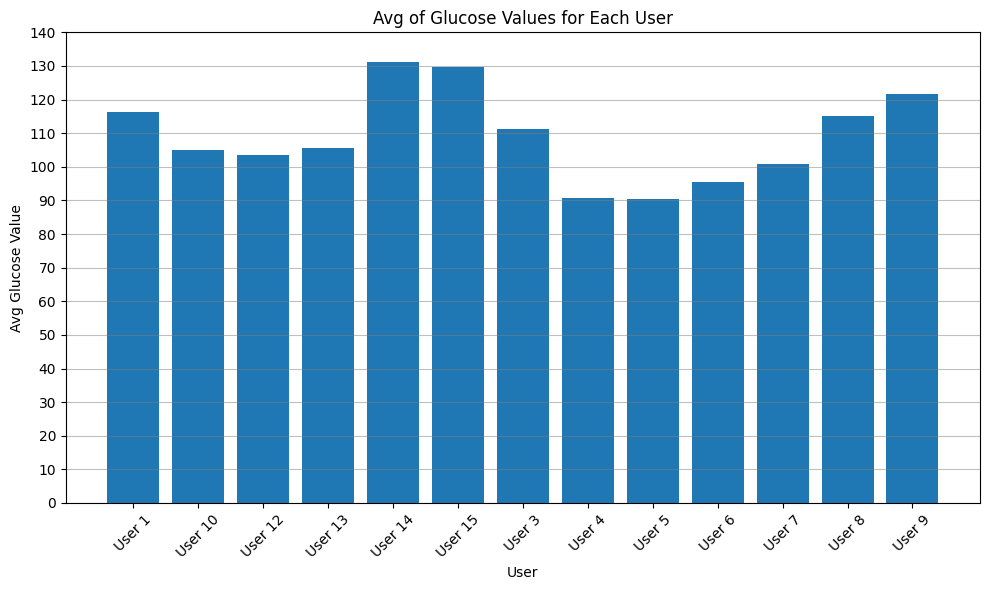

In [115]:

plt.figure(figsize=(10, 6))
plt.bar(users, glucose_avg)
plt.xlabel("User")
plt.ylabel("Avg Glucose Value")
plt.title("Avg of Glucose Values for Each User")
plt.xticks(rotation=45)
plt.ylim(0, 140)
plt.grid(axis='y', color='gray', alpha=0.5)
plt.yticks(range(0, 141, 10))
plt.tight_layout()
plt.show()